In [1]:
PROJDIR=file.path('../../../data/raw_data/cross_species_peak_orthologs')

#######################################
### set up libraries and functions ####
ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F, repr.plot.width=12, repr.plot.height=6.5)
suppressMessages(library(Seurat))

source('../hal_scripts/narrowPeakFunctions.R')
parallel::detectCores()

[1] 40

In [2]:
# # set up future for parallelization
library(future)
library(future.apply)
plan("sequential")
options(future.globals.maxSize = 180 * 1024^3)

# 1) visualize cross-species cluster integration

In [3]:
## load the seurat object
geneScoreMergedRDS_fn = file.path(PROJDIR, 'rdas', 'geneScoreMergedSeurat.rds')
obj_seurat = readRDS(file = geneScoreMergedRDS_fn)

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


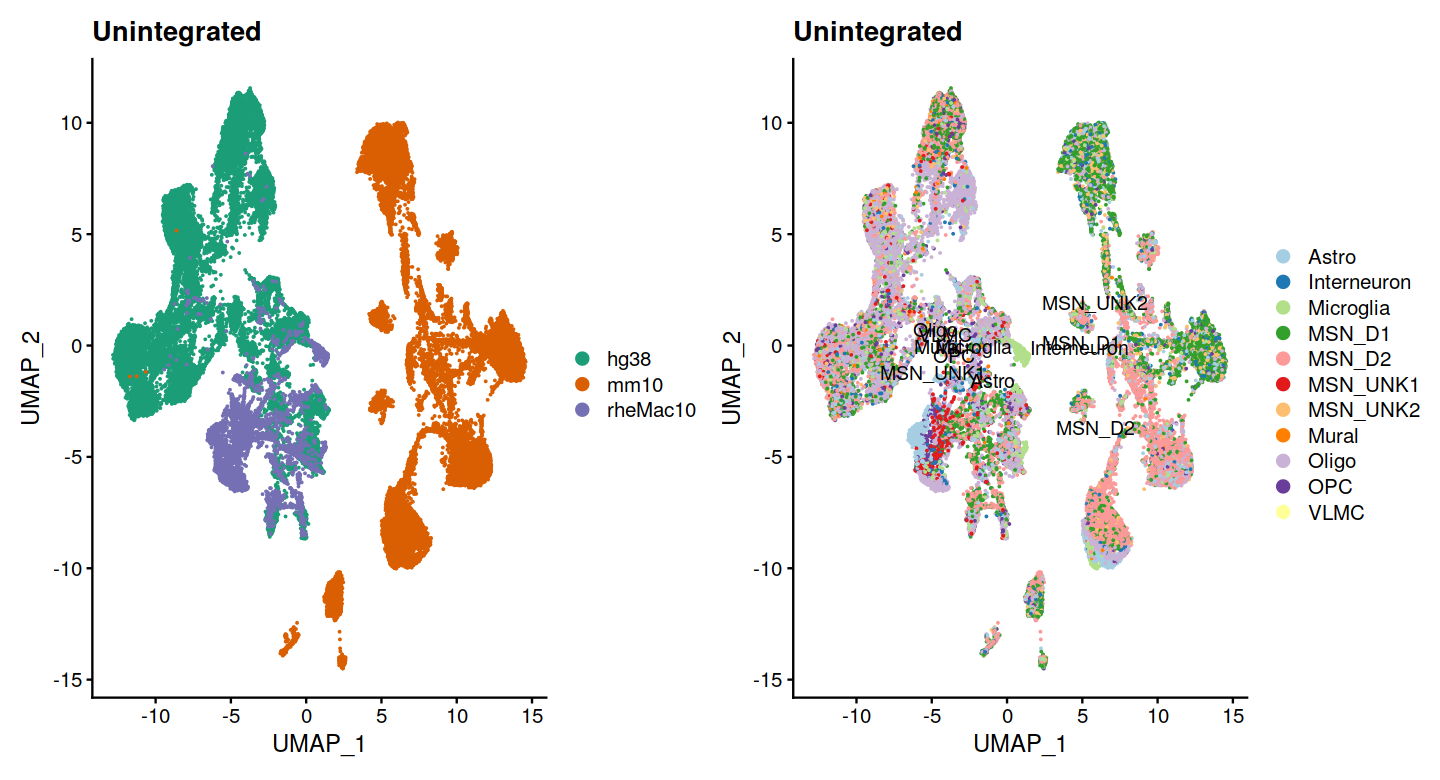

In [4]:
p_unintegrated_species = 
    DimPlot(object = obj_seurat, label = FALSE, group.by = 'Species', cols = 'Dark2') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_clusters2 = 
    DimPlot(object = obj_seurat, label = TRUE, group.by = 'Clusters2', cols = 'Paired') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_species + p_unintegrated_clusters2

# 2) integration with Seurat Intergration

In [9]:
## split seurat object up by species
obj_seurat.list = SplitObject(obj_seurat, split.by = 'Sample')
names(obj_seurat.list)
obj_seurat.list <- lapply(X = obj_seurat.list, FUN = function(x) {
    # data already normalized and scaled
    x <- FindVariableFeatures(x, verbose = FALSE)
})

# features <- SelectIntegrationFeatures(object.list = obj_seurat.list, nfeatures = 2000)
features <- rownames(obj_seurat)

## compute SVD on all peaks
obj_seurat.list <- lapply(X = obj_seurat.list, FUN = function(x) {
    x <- RunPCA(x, verbose = FALSE)
})

[1] "09_1589.CAUD"         "14_1018.CAUD"         "06_0615.CAUD"        
[4] "CAUD_WS1H_STA682A131" "CEMBA180813_5E"       "CEMBA171219_4D"      
[7] "CEMBA171214_4D"       "CEMBA180820_5E"

In [ ]:
# find integration anchors between species
anchors <- FindIntegrationAnchors(
    object.list = obj_seurat.list, reduction = 'cca', anchor.features = features,
    k.filter = NA, assay = rep('RNA', length(obj_seurat.list)))

Scaling features for provided objects

Finding all pairwise anchors

Running CCA



In [ ]:
# integrate data and create a new merged object
integrated <- IntegrateData(anchors)

In [ ]:
# we now have a "corrected" TF-IDF matrix, and can run LSI again on this corrected matrix
integrated <- ScaleData(integrated, verbose = FALSE)
integrated <- RunPCA(integrated, verbose = FALSE)
integrated <- RunUMAP(integrated, dims = 1:30)

In [ ]:
p_integrated_species = 
    DimPlot(object = integrated, label = FALSE, group.by = 'Species', cols = 'Dark2') +
    ggplot2::ggtitle("Seurat integration")

p_integrated_clusters2 = 
    DimPlot(object = integrated, label = TRUE, group.by = 'Clusters2', cols = 'Paired') +
    ggplot2::ggtitle("Seurat integration")

p_integrated_species + p_integrated_clusters2

In [ ]:
DimPlot(object = integrated, label = TRUE, split.by = 'Species', cols = 'Paired') +
    ggplot2::ggtitle("Seurat integration")

In [ ]:
## save the seurat object
geneScoreRDS_fn = file.path(PROJDIR, 'rdas', 'geneScoreSeuratCCA.rds')
system(paste('mkdir -p', dirname(geneScoreRDS_fn)))
saveRDS(integrated, file = geneScoreRDS_fn)

In [ ]:
# geneScoreRDS_fn = file.path(PROJDIR, 'rdas', 'geneScoreSeuratCCA.rds')
# integrated = readRDS(file = geneScoreRDS_fn)